In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import sys
import seaborn as sns
import os
from cycifsuite.detect_lost_cells import *

## Get data from a local directory.

In [54]:
path = ('N:/HiTS Projects and Data/Personal/Jake/mcf10a/raw_data_selected_features')
os.chdir(path)
raw_expr_data = pd.read_hdf('pooled_expr_data_5_features.hdf',index_col=0)
metadata = pd.read_csv('../proper_FFC_metadata.csv',index_col=0)

In [22]:
qc_cols = [x for x in raw_expr_data.columns if ('dna' in x) & ('int_mean' in x) & ('nuc' in x) & ('nucring' not in x)]
# The QC process only uses data of the DNA channel, and thus other channels are cropped off.
cell_count_qc = raw_expr_data[qc_cols].copy()
cell_count_qc.loc[:,'pcf'] = ['_'.join(x.split('_')[:-1]) for x in cell_count_qc.index]

# Getting the threshold value for move-out effect

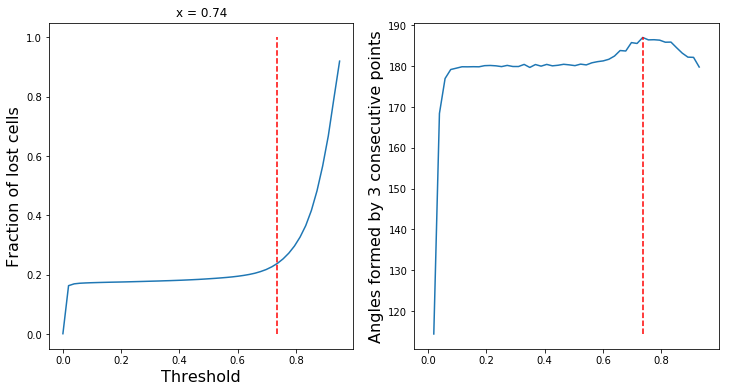

In [23]:
x,y,t = ROC_lostcells(cell_count_qc.iloc[:,1:9], cutoff_min=0, cutoff_max=0.95,steps=50, filtering_method='cycle_diff',left_stepping=False)

## Alternative threshold plot as seen as Figure 3 in the doc.

Text(0, 0.5, 'Mean fraction of lost cells across all fields')

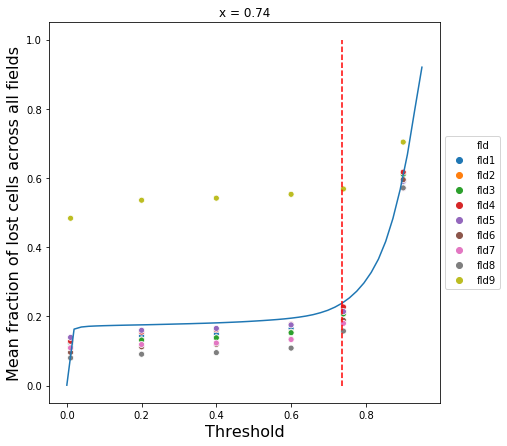

In [24]:
def plot_elbow_v2(x, y, elbow_idx, color='red', figname=None):
    plt.figure(figsize=(7,7))
    # plotting threshold by fraction of lost cells
    plt.plot(x, y)
    plt.plot([x[elbow_idx], x[elbow_idx]], [
        0, 1], color=color, linestyle='dashed')
    plt.title('x = {:.2f}'.format(x[elbow_idx]))
    plt.xlabel('Threshold', fontsize=16)
    plt.ylabel('Fraction of lost cells', fontsize=16)

plot_elbow_v2(x,y,38)
for t in [0.01,0.2,0.4,0.6,0.74, 0.9]:
    _, lc_cv_down = get_lost_cells(cell_count_qc.iloc[:,1:9], t,8,'cycle_diff')
    lc_fraction,_,_ = get_mean_lost_cell_fraction(cell_count_qc, lc_cv_down, fld_stat_method='individual')
    lc_fraction = pd.DataFrame(lc_fraction)
    lc_fraction.columns = ['fraction']
    lc_fraction['fld'] = [x.split('_')[-1] for x in lc_fraction.index]
    lc_fraction = lc_fraction.groupby('fld').mean()
    if t!= 0.9:
        sns.scatterplot([t]*9, lc_fraction.fraction, hue = lc_fraction.index, legend=None)
    else:
        sns.scatterplot([t]*9, lc_fraction.fraction, hue = lc_fraction.index)

plt.legend(bbox_to_anchor = (1,0.5), loc='center left')
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Mean fraction of lost cells across all fields', fontsize=16)

# Getting the threshold value for the move-in effect

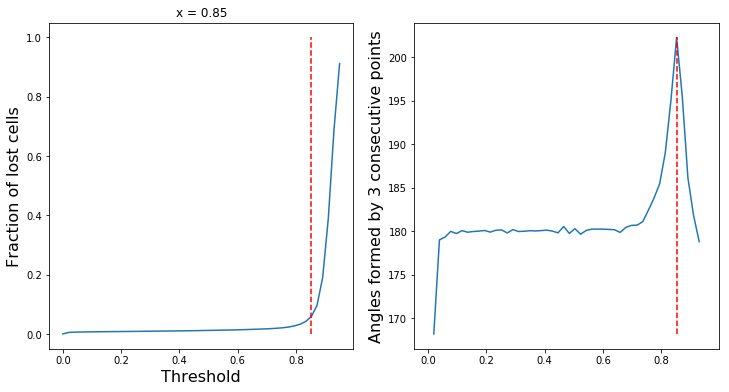

In [26]:
x,y,t = ROC_lostcells(cell_count_qc.iloc[:,1:9], cutoff_min=0, cutoff_max=0.95,steps=50, filtering_method='cycle_diff', direction='up')

# Get a list of lost cells based on the above thresholds

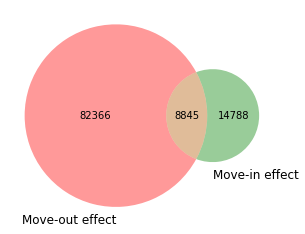

In [28]:
_, lc_cv_down = get_lost_cells(cell_count_qc.iloc[:,1:9], 0.74,8,'cycle_diff')
_, lc_cv_up = get_lost_cells(cell_count_qc.iloc[:,1:9], 0.85,8,'cycle_diff', direction='up')
total_loss = list(set(lc_cv_down+lc_cv_up))
lc_fraction,_,_ = get_mean_lost_cell_fraction(cell_count_qc, total_loss, fld_stat_method='individual')
# check Overlap between the two methods
venn2([set(lc_cv_down), set(lc_cv_up)],set_labels=['Move-out effect', 'Move-in effect'])

# Dropping bad field location(s) and row(s)
The `find_bad_regions` function will take a table of per field lost cell fraction as input.

The addition columns describle the field will be evaluated. For example, in this case, 'plate_well' for a particular well in a plate is being evaluated for its mean lost cell fraction, and if such value significantly deviated from the overall value across the whole experiment, that paticular well will be dropped.

A field with more than 90% lost is defined as a bad field. A field location or row with excessive number of bad fields will be dropped. 

In [55]:
lc_fraction = pd.DataFrame(lc_fraction)
lc_fraction.rename({'fld':'lc_fraction'},inplace=True,axis='columns')
lc_fraction['plate_well'] = [x[:-5] for x in lc_fraction.index]
lc_fraction['field'] = [x.split('_')[-1] for x in lc_fraction.index]
lc_fraction['plate_row'] = [x.split('_')[0] + '_' +  x.split('_')[1][0] for x in lc_fraction.index]
bad_pwfs = find_bad_regions(lc_fraction, automatic=True)

# dropping lost cells and bad field location and rows
metadata = update_metadata(metadata, total_loss, bad_pwfs)
metadata.to_csv('../proper_FFC_metadata.csv')

13_C05 with a bad ratio at 0.89 is considered a bad plate_well
13_D05 with a bad ratio at 0.89 is considered a bad plate_well
18_E05 with a bad ratio at 1.00 is considered a bad plate_well
18_E06 with a bad ratio at 1.00 is considered a bad plate_well
18_E07 with a bad ratio at 0.89 is considered a bad plate_well
18_E08 with a bad ratio at 1.00 is considered a bad plate_well
18_E10 with a bad ratio at 0.89 is considered a bad plate_well
8_D04 with a bad ratio at 1.00 is considered a bad plate_well
8_E04 with a bad ratio at 1.00 is considered a bad plate_well
fld9 with a bad ratio at 0.23 is considered a bad field
18_E with a bad ratio at 0.85 is considered a bad plate_row


# Plotting

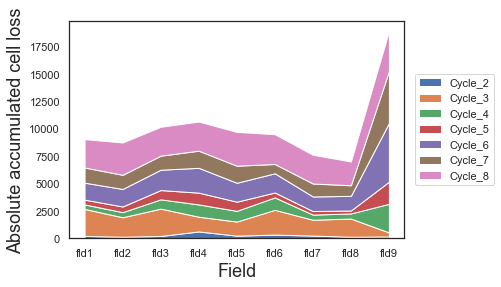

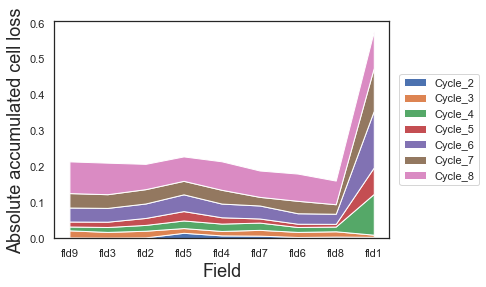

In [49]:
df_down, lc_cv_down = get_lost_cells(cell_count_qc.iloc[:,1:9], 0.74,8,'cycle_diff')
df_up, lc_cv_up = get_lost_cells(cell_count_qc.iloc[:,1:9], 0.76,8,'cycle_diff', direction='up')
total_loss = list(set(lc_cv_down+lc_cv_up))
t,_,_ = get_mean_lost_cell_fraction(cell_count_qc, total_loss, 'individual')
plot_lost_cell_per_cycle_stacked_area(df_down)
plot_lost_cell_per_cycle_stacked_area(df_down, metadata, in_fraction=True)

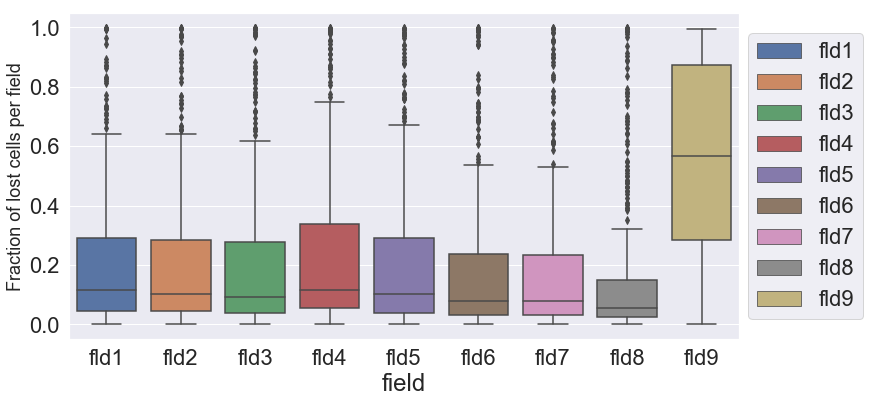

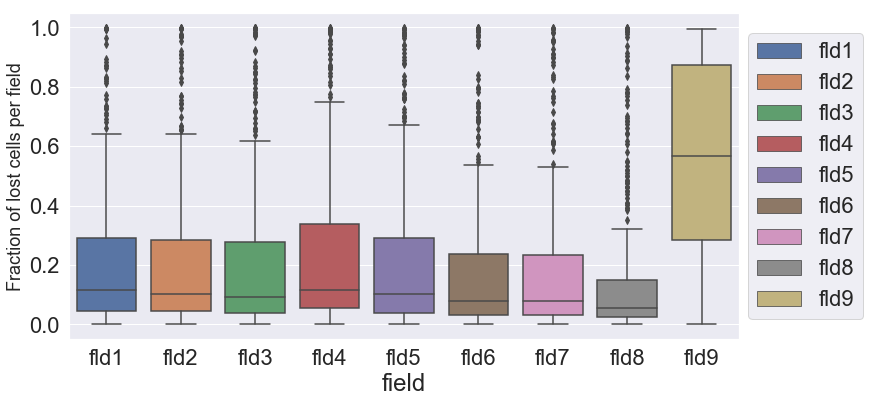

In [48]:
plot_lc_by_fld(t)
# Version without E row of plate 18.
non_18_e = [x for x in t.index if '18_cell_E' not in x]
non_18_e = t.loc[non_18_e]
plot_lc_by_fld(non_18_e)

# Make condition boxplot of lost cells per well

In [51]:
# Get rid of all cells in fld9 and row E
lc_non_f9_e18 = [x for x in total_loss if 'fld9' not in x]
lc_non_f9_e18 = [x for x in lc_non_f9_e18 if not (('18_'in x) & ('E' in x))]
all_cells_non_f9 = [x for x in metadata.index if 'fld9' not in x]
all_cells_non_f9 = [x for x in all_cells_non_f9 if not (('18_'in x) & ('E' in x))]
# Calculate per-well fraction of lost cells
metadata = metadata.loc[all_cells_non_f9]
metadata['pw'] = metadata.Plate.astype(str).str.zfill(2) + '_' + metadata.Well
metadata['condition'] = metadata.ligand + '_' + metadata.time.astype(str).str.zfill(2)
condition_cc = metadata.groupby(['pw']).count().iloc[:,0]
pw_meta = metadata.groupby(['pw']).first()[['condition', 'ligand']]
lost_cells = metadata.loc[lc_non_f9_e18].groupby(['pw']).count().iloc[:,0]
lost_cells = lost_cells.reindex(condition_cc.index, fill_value=0)
lost_cells = lost_cells / condition_cc
lost_cells.name = 'Fraction_of_lost_cells_per_well'
lost_cells = pd.DataFrame(lost_cells)
lost_cells['test_cond'] = pw_meta.condition
lost_cells['time'] = [x[-2:] for x in pw_meta.condition]

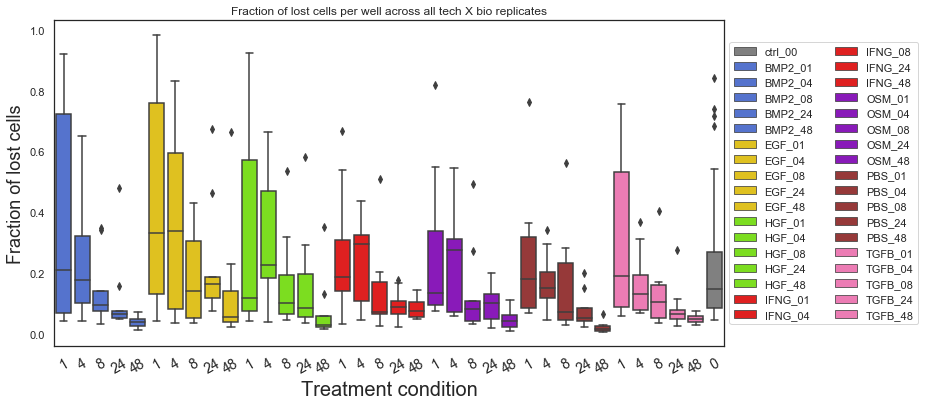

In [52]:
lost_cells = lost_cells.sort_values('test_cond')
all_cond = lost_cells.test_cond.unique().tolist()
all_cond = [all_cond[-1]]+all_cond[:-1]
all_cond = pd.Series('',index=all_cond)
all_cond[0] = 'grey'
colors = ['royalblue','gold','lawngreen','red','darkviolet','brown','hotpink']
for i in range(7):
    all_cond[1+i*5:6+i*5] = colors[i]
all_times = lost_cells['time'].unique().tolist()
all_times = all_times[:-1]*7+['0']
all_times = [int(x) for x in all_times]
plt.figure(figsize=(12,6))
g = sns.boxplot(x='test_cond',y='Fraction_of_lost_cells_per_well',hue='test_cond', 
            hue_order=all_cond.index, palette=all_cond,data=lost_cells, dodge=False)
plt.ylabel('Fraction of lost cells', fontsize=18)
plt.xlabel('Treatment condition', fontsize=20)
plt.legend(bbox_to_anchor = (1,0.5),loc='center left', ncol=2 )
plt.title('Fraction of lost cells per well across all tech X bio replicates')
g.set_xticklabels(all_times,fontsize=14)
_ = plt.xticks(rotation=30)